# Single Cell Segmentation Notebook

<font size = 4>This notebook uses Cellpose 2.0 for single-cell segmentation. Please ensure that your images file type is `.tif`. If your images have `_maskes` in the name this notebook will automatically skip over those images.

This notebook uses a custom pretrained model on your images. You will also need to ensure that your GPU is working. It is recommended to run this notebook on the T4 GPU with the High-RAM option.

Mount your google drive to access all your image files and folders. This also ensures that all of ouput data is saved to your google drive.

**If you are having trouble please refer to this document-> [Click Here!](https://docs.google.com/document/d/1V2_7eRCLVyZEPhSXaYh51OHRORT4UMGS3ajQ6RbXYdU/edit?usp=sharing)**

## Setup

We will first install cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

This cell checks the CUDA version and that GPU is working in cellpose. This also imports other neccesary libraries.

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
import skimage.io
from skimage.measure import label, regionprops
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f"Is the User's GPU activated? {yn[use_GPU]}")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Wed Apr  3 02:20:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  7

## 1. Mounting your google drive

Please mount your google drive and with the two folders. The first folder should be the input folder with all of your input images. The second folder should be an empty folder because this folder will hold of all the morphology data and processed image. **Please ensure that your images end in** `.tif`.

In [3]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the run cell.

#@markdown * Sign in your Google Account.

#@markdown * Allow the notebook access to your Google Drive.


#@markdown * Click on "Files" site on the left in Colab. Your Google Drive folder should now be available here as "drive" or "gdrive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')




Mounted at /content/gdrive


##Training your own Cellpose Model (Optional)
To understand how to train a Cellpose Model please watch this YouTube video -> [Click Here!](https://www.youtube.com/watch?v=5qANHWoubZU)

In [ ]:
from cellpose import io, models, train, metrics
import torch
#Define where the patch file will be saved
base = "/content"
#@markdown ###Path to images and masks:
train_dir = "human_in_the_loop/train" #@param {type:"string"}
test_dir = "human_in_the_loop/test" #@param {type:"string"}

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
initial_model = "cyto" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "new_Cellpose_model" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Blue" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here (Not Recommended):

Second_training_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

logger = io.logger_setup()

channels = [chan, chan2]

# Get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

# Define model parameters
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# Train the model
new_model_path = train.train_seg(net=model.net, train_data=train_data, train_labels=train_labels,
                                 test_data=test_data, test_labels=test_labels,
                                 channels=channels, save_path=train_dir,
                                 n_epochs=n_epochs, learning_rate=learning_rate,
                                 weight_decay=weight_decay, nimg_per_epoch=8,
                                 model_name=model_name)

# Load the trained model
trained_model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)
trained_model.net.load_state_dict(torch.load(new_model_path))

# Get the parameters of the trained model
trained_model_params = trained_model.net.parameters()

# Diameter of labels in training images
diam_labels = trained_model.diam_mean.item()

# Get test files (during training, test_data is transformed so we will load it again)
test_output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = test_output[:2]

# Run model on test images
masks_test = trained_model.eval(test_data,channels=channels,diameter=diam_labels)[0]

# Check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks_test)[0]
print(f'average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


# Use custom model to segment images

Take custom trained model from above, or upload your own model to google drive / colab runtime.

## 2. Parameters

In [4]:
#@markdown ###Custom model path (full path):

model_path = "/content/gdrive/MyDrive/colab_test/green_model_train/models/CP_tissuenet4" #@param {type:"string"}

#@markdown ###Path to images and output folder(s):

input_folder = "/content/gdrive/MyDrive/colab_test/testingLOL" #@param {type:"string"}

output_folder = "/content/gdrive/MyDrive/colab_test/Well_A3_Output" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown (Not Recommended)If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "None" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 1 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=-1 #@param {type:"slider", min:-6, max:6, step:1}


## 3. Running the model

In [5]:
files = io.get_image_files(input_folder,'_masks')
print(files)
images = [io.imread(f) for f in files]
# creating lists for the processed images
processed_images = []

model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if the users diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

print("running the segmentation model")
  # run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )


#Iterate through the processed masks and add them to the list
for mask in masks:
    processed_images.append(mask)
print(f"Number of processed images: {len(masks)}")
#Un-comment code if you want to save your segmented images (code used from cellpose function)
#io.save_masks(images,
              #masks,
              #flows,
              #files,
              #channels=[chan, chan2],
              #png=True, # save masks as PNGs and save example image
              #tif=True, # save masks as TIFFs
              #save_txt=True, # save txt outlines for ImageJ
              #save_flows=False, # save flows as TIFFs
              #save_outlines=False, # save outlines as TIFFs
              #)


['/content/gdrive/MyDrive/colab_test/testingLOL/Copy of 20230930_164848_489__WellA1_ChannelCamera - Blue,Camera - Transmission,Camera - Green,Camera - Gold_Seq0000_A1_0017_Camera - Green.tif', '/content/gdrive/MyDrive/colab_test/testingLOL/Copy of Copy of 20230930_161325_546__WellA2_ChannelCamera - Blue,Camera - Transmission,Camera - Green,Camera - Gold_Seq0001_A2_0000_Camera - Green.tif', '/content/gdrive/MyDrive/colab_test/testingLOL/Copy of Copy of 20230930_161325_546__WellA2_ChannelCamera - Blue,Camera - Transmission,Camera - Green,Camera - Gold_Seq0001_A2_0007_Camera - Green.tif', '/content/gdrive/MyDrive/colab_test/testingLOL/Copy of Copy of 20230930_161325_546__WellA2_ChannelCamera - Blue,Camera - Transmission,Camera - Green,Camera - Gold_Seq0001_A2_0008_Camera - Green.tif', '/content/gdrive/MyDrive/colab_test/testingLOL/Copy of Copy of 20230930_161325_546__WellA2_ChannelCamera - Blue,Camera - Transmission,Camera - Green,Camera - Gold_Seq0001_A2_0009_Camera - Green.tif', '/conte

# 4. Quantification of Intensity **(Please Read!)**

> Instructions for raw and quality control intensity measurement

**If you just want to find the intensity on the raw masks then you can use the two code cells below.**
****
**If you want to find the intensity after  quality control after you run this cell go to the quality control section. Complete the quality control cell and then run the cell below it to output the csv file containing raw and normalized intensity.**

In [ ]:
import os
import pandas as pd
import numpy as np
from skimage import io

#@markdown ####Path to the folder containing new channel images
# Path to the folder containing new channel images
images_path = "/content/gdrive/MyDrive/colab_test/HS_09_p1_A1_Green" #@param

# Initialize an empty list to store data for all images
all_images_data = []

print("Iterate through each green channel image and its corresponding processed masks")
# Iterate through each green channel image and its corresponding processed masks
for other_image_filename, masks in zip(os.listdir(images_path), processed_images):
    other_image_path = os.path.join(images_path, other_image_filename)
    other_image = io.imread(other_image_path)

    mask_data_list = []

    for mask_number in np.unique(masks):
        mean_intensity_with_background = np.mean(green_image[masks == mask_number])

        # Append to the cell_data_list for each image
        mask_data_list.append({
            "Cell ID": f"{mask_number}",
            "intensity_raw": mean_intensity_with_background
        })

    # Calculate average intensity and number of cells for each image
    avg_intensity = np.mean([mask_data['intensity_raw'] for mask_data in mask_data_list])
    num_masks = len(mask_data_list)
    avg_intensity_per_mask = avg_intensity / num_masks

    # Append data for each image to the all_images_data list
    all_images_data.append({
        "filename": other_image_filename,
        "avg_intensity": avg_intensity,
        "num_cells": num_masks,
        "avg_intensity_per_cell": avg_intensity_per_mask
    })

    # Create a DataFrame from the cell data list for each image
    data = pd.DataFrame(mask_data_list)

    # Save the DataFrame as a CSV file for each image
    csv_filename = os.path.join(output_folder, f"{other_image_filename}_intensity_results.csv")
    data.to_csv(csv_filename, index=False)

# Create a DataFrame for all images and save it as a single CSV file
all_images_df = pd.DataFrame(all_images_data)
all_images_csv_filename = os.path.join(output_folder, "all_images_intensity_results.csv")
all_images_df.to_csv(all_images_csv_filename, index=False)


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(np.zeros_like(data['intensity_raw']), data['intensity_raw'], label='Day 1', s=100)

# Find the mean line for the section
mean_intensity = np.mean(data['intensity_raw'])
plt.axhline(y=mean_intensity, color='blue', linestyle='-', linewidth=2, label='Mean Day 1', xmin=0.05, xmax=0.3)
# Set x-axis labels
plt.xticks([0], ['Day 1'])

# Set y-axis limit to 3
plt.ylim(0, 3)

# Add labels and title
plt.xlabel('Timepoint (Days)')
plt.ylabel('Intensity')
plt.title('Title')
plt.legend()

# Save the plot for each image
plt.savefig(os.path.join(output_folder, "title.png"))

# Show the plot
plt.show()

Finding the intensity of the masks on other images.

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

#@markdown ####Path to the combined folder containing both regular and green channel images
new_images_folder = "/content/gdrive/MyDrive/colab_test/Well_B2_green" #@param
#@markdown ####The name for the file containing all of the randomly selected masks
random_masks_file_name = "name" #@param
# Initialize an empty list to store data for all images
all_images_data = []
selected_masks_intensity = []

# Iterate through each other channels imagse and its corresponding processed masks
print('Iterating through each channels images and its corresponding processed masks')
for other_image_filename, masks in zip(os.listdir(new_images_folder), processed_images):
    other_image_path = os.path.join(new_images_folder, other_image_filename)
    other_image = io.imread(other_image_path)

    # Initialize an empty list to store cell data for each image
    mask_data_list = []
    print("creating CSV files for all images")
    for mask_number in np.unique(masks):
        mean_intensity_with_background = np.mean(other_image[masks == mask_number])

        # Append to the cell_data_list for each image
        mask_data_list.append({
            "Cell ID": f"{mask_number}",
            "intensity_raw": mean_intensity_with_background
        })


    print("Randomly selecting masks")
    #@markdown ####Randomly select ~27 cells per image
    num_masks_per_image = 27 #@param

    # Use the previously calculated intensity values for selected cells
    selected_indices = np.random.choice(len(mask_data_list), size=min(num_masks_per_image, len(mask_data_list)), replace=False)
    selected_masks_intensity.extend([mask_data_list[idx]['intensity_raw'] for idx in selected_indices])

    # Calculate average intensity and number of cells for each image
    avg_intensity = np.mean([mask_data['intensity_raw'] for mask_data in mask_data_list])
    num_masks = len(mask_data_list)
    print(num_masks)
    avg_intensity_per_mask = avg_intensity / num_masks

    # Append data for each image to the all_images_data list
    all_images_data.append({
        "filename": other_image_filename,
        "avg_intensity": avg_intensity,
        "num_cells": num_masks,
        "avg_intensity_per_cell": avg_intensity_per_mask
    })

    # Create a DataFrame from the cell data list for each image
    data = pd.DataFrame(mask_data_list)

    print(f"Saving a dataframe/CSV file for each image")
    # Save the DataFrame as a CSV file for each image
    csv_filename = os.path.join(output_folder, f"{other_image_filename}_intensity_results.csv")
    data.to_csv(csv_filename, index=False)

#print(f"reversing the selected_cells_intensity list becasue sometimes Google Drive sorts the images backwards if this is not the case please comment this line out")
# Reverse the selected_cells_intensity list
#selected_cells_intensity.reverse()

# Create the CSV file for all cells with intensity and corresponding day
mask_data = pd.DataFrame()
for idx, intensity in enumerate(selected_cells_intensity):
    mask_data = mask_data.append({
        "Cell ID": idx + 1,
        "Intensity": intensity,
    }, ignore_index=True)
mask_data.to_csv(os.path.join(output_folder, f'{random_masks_file_name}.csv'), index=False)

****
You will need to change some variables in this code cell.

*   You should change the labels of the scatter plots variable "plt.scatter(np.zeros_like(selected_cells_intensity), selected_cells_intensity, label='Day 1', s=100)" Change the "label='Day 1'" to your desire

*   Next change the "plt.xticks([0], ['Day 1'])" to be your desired labels on the x-axis

*   After, change the limit that is set on the y-axis "plt.ylim(0, 3)" right now the y-axis only goes from 0-3.

*   Change the title of the graph "plt.title('Title')"

*   Finally, change the name of the file. It is located in the code "plt.savefig". The part you should change is "file_name.png"

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

# Create scatterplot
plt.figure(figsize=(10, 6))

print("plotting the graph")
# Scatterplot for the section
plt.scatter(np.zeros_like(selected_masks_intensity), selected_masks_intensity, label='Day 1', s=100)

# Add mean lines for the section
plt.axhline(y=np.mean(selected_masks_intensity), color='blue', linestyle='-', linewidth=2, label='Mean Day 1', xmin=0.05, xmax=0.3)

# Set x-axis labels
plt.xticks([0], ['Day 1'])

# Set y-axis limit to 5
plt.ylim(0, 3)

# Add your own labels and title
plt.xlabel('Timepoint (Days)')
plt.ylabel('Intensity')
plt.title('Title')

# Show the legend
plt.legend()

# Create separate box plots for each day
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')

# Boxplot for Day 1
plt.boxplot(selected_masks_intensity, vert=True, positions=[0], boxprops=boxprops, medianprops=medianprops, showfliers=False, labels=['Day 1'])
# Save the plot
plt.savefig(os.path.join(output_folder, "file_name_here.png"))

# Show the plot
plt.show()

##Saving the output to *_seg.npy prior to quality control

You will see the files save in the folder which path you assigned to the output_folder variable.

In [ ]:
import shutil

io.masks_flows_to_seg(images, masks, flows, diameter * np.ones(len(masks)), files, [chan, chan2])

# Get a list of the processed files in the input folder
input_files = os.listdir(input_folder)

# Move the files to the output folder in Google Drive
for file in input_files:
  if file.endswith("_seg.npy"):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)
            shutil.move(input_path, output_path)

## Save output masks to tiffs (Optional)

In [ ]:
from cellpose import io

# Assuming images, masks, flows, and files are your lists containing corresponding data
# Save masks to disk
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              )


# 5. Quality Control

This code cell removes any cells from the border of the images. As well as removes any cells with an area greater than or less than the area percentile of your choice.

In [ ]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import numpy as np

processed_images_qc = []
#@markdown ##The range of allowed area in the dataset
#@markdown #### First percentile (ex. keeps if cell's area > than 20% of the total area for all the cells)
x1 = 20 #@param
#@markdown #### Second percentile (ex. keeps if cell's area < than 80% of the total area for all the cells)
x2 = 80 #@param
# Iterate over the list of segmented images and masks.
for image, mask in zip(processed_images, masks):

    print("Clearing the border of cells for each image")
    # Clear the border of the image.
    image_without_edge_cells = clear_border(image)

    # Label connected components in the binary mask.
    labeled_mask = label(mask)

    # Get region properties (including area) for each labeled region.
    regions = regionprops(labeled_mask)

    # Check if there are any regions before calculating percentiles.
    if regions:
        print("Calculating the 20th and 80th percentiles of region areas")
        # Calculate the 10th and 90th percentiles of region areas.
        areas = [region.area for region in regions]
        q1 = np.percentile(areas, x1)
        q3 = np.percentile(areas, x2)

        print("Filtering out regions with area below lower and above upper")
        # Filter out regions with area below Q1 and above Q3.
        filtered_regions = [region.label for region in regions if q1 <= region.area <= q3]

        # Create a boolean mask indicating whether each region should be kept.
        keep_mask = np.isin(labeled_mask, filtered_regions)

        # Apply the boolean mask to the image.
        image_without_outlier_cells = image_without_edge_cells * keep_mask

        processed_images_qc.append(image_without_outlier_cells)
    else:
        # Handle the case when there are no regions in the labeled mask.
        processed_images_qc.append(image_without_edge_cells)


Clearing the border of cells for each image
Calculating the 20th and 80th percentiles of region areas
Filtering out regions with area below lower and above upper
Clearing the border of cells for each image
Calculating the 20th and 80th percentiles of region areas
Filtering out regions with area below lower and above upper
Clearing the border of cells for each image
Calculating the 20th and 80th percentiles of region areas
Filtering out regions with area below lower and above upper
Clearing the border of cells for each image
Calculating the 20th and 80th percentiles of region areas
Filtering out regions with area below lower and above upper
Clearing the border of cells for each image
Calculating the 20th and 80th percentiles of region areas
Filtering out regions with area below lower and above upper
Clearing the border of cells for each image
Calculating the 20th and 80th percentiles of region areas
Filtering out regions with area below lower and above upper
Clearing the border of cells

### Overlapping Cells (Optional, will increase time)
> Instructions for when to use this cell

This code cell is specifically meant to remove overlapping cells. If you know that your images contain overlapping cells and wish to only utilize dispersed cell data then you should consider this cell.

In [7]:
import numpy as np
from skimage import measure

def remove_touching_masks_and_relabel(processed_images):
    cleaned_images = []

    for image in processed_images:
        #Labeling the image
        labeled_image = measure.label(image, background=0)

        # Finding all unique labels excluding the background
        unique_labels = np.unique(labeled_image[labeled_image > 0])

        # Prepare an image to store non-touching masks with new labels
        non_touching_labeled_image = np.zeros_like(labeled_image)

        # New label counter for non-touching masks
        new_label = 1

        for label in unique_labels:
            # Extract the current object
            current_mask = (labeled_image == label)

            # Identify the border of the current object
            border = measure.find_contours(current_mask, level=0.5)

            #Checking if the border is touching another mask's border
            touching = False
            for contour in border:
                for y, x in contour:
                    # Adjusted to consider borders' direct adjacency to other masks
                    adj_pixels = labeled_image[max(int(y)-1,0):int(y)+2, max(int(x)-1,0):int(x)+2]
                    adj_labels = np.unique(adj_pixels)
                    # If adjacent pixels contain different labels then classify it as touching another mask
                    if len(adj_labels[adj_labels != label]) > 1:
                        touching = True
                        break
                if touching:
                    break

            #If not touching, assign it to the new labeled image with a unique new label
            if not touching:
                non_touching_labeled_image[current_mask] = new_label
                new_label += 1

        #Apend the new processed Image
        cleaned_images.append(non_touching_labeled_image)

    return cleaned_images
cleaned_images = remove_touching_masks_and_relabel(processed_images_qc)

# 6. Quantification of Intensity With Quality Control

In [ ]:
import os
import pandas as pd
import numpy as np
from skimage import io

#@markdown ####Path to the folder containing new channel images
images_path = "/content/gdrive/MyDrive/colab_test/Green" #@param

# Initialize an empty list to store data for all images
all_images_data = []

print("Iterate through each green channel image and its corresponding processed masks")
# Iterate through each green channel image and its corresponding processed masks
for other_image_filename, masks in zip(os.listdir(images_path), cleaned_images):
    other_image_path = os.path.join(images_path, other_image_filename)
    other_image = io.imread(other_image_path)

    # Initialize an empty list to store cell data for each image
    mask_data_list = []

    for mask_number in np.unique(masks):
      if mask_number !=0
        mean_intensity_without_background = np.mean(other_image[masks == mask_number])

        # Append to the cell_data_list for each image
        mask_data_list.append({
            "Cell ID": f"{mask_number}",
            "intensity_raw": mean_intensity_without_background
        })

    # Calculate average intensity and number of cells for each image
    avg_intensity = np.mean([mask_data['intensity_raw'] for mask_data in mask_data_list])
    num_masks = len(mask_data_list)
    print(num_masks)
    avg_intensity_per_mask = avg_intensity / num_masks

    # Append data for each image to the all_images_data list
    all_images_data.append({
        "filename": green_image_filename,
        "avg_intensity": avg_intensity,
        "num_cells": num_cells,
        "avg_intensity_per_cell": avg_intensity_per_cell
    })

    # Create a DataFrame from the cell data list for each image
    data = pd.DataFrame(mask_data_list)

    # Save the DataFrame as a CSV file for each image
    csv_filename = os.path.join(output_folder, f"{other_image_filename}_intensity_results.csv")
    data.to_csv(csv_filename, index=False)

# Create a DataFrame for all images and save it as a single CSV file
all_images_df = pd.DataFrame(all_images_data)
all_images_csv_filename = os.path.join(output_folder, "qc_all_images_intensity_results.csv")
all_images_df.to_csv(all_images_csv_filename, index=False)


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(np.zeros_like(data['intensity_raw']), data['intensity_raw'], label='Day 1', s=100)

# Find the mean line for the section
mean_intensity = np.mean(data['intensity_raw'])
plt.axhline(y=mean_intensity, color='blue', linestyle='-', linewidth=2, label='Mean Day 1', xmin=0.05, xmax=0.3)
# Set x-axis labels
plt.xticks([0], ['Day 1'])

# Set y-axis limit
plt.ylim(0, 3)

# Add your own labels and title
plt.xlabel('Timepoint (Days)')
plt.ylabel('Intensity')
plt.title('Title')

plt.legend()

#Save the plot for each image
plt.savefig(os.path.join(output_folder, "title.png"))

# Show the plot
plt.show()

Finding the intensity of the masks on other images with background subtraction.

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

#@markdown ###Path to the folder containing other channel images
other_channel_folder = "/content/gdrive/MyDrive/colab_test/testingLOL" #@param

#@markdown ###File name for randomly selected csv file (Do not put .csv)
qc_csv_file_name = "qc_here"#@param
# Initialize an empty list to store data for all images
all_images_data = []
selected_masks_intensity = []
print("Iterate through each green channel image and its corresponding processed masks")
# Iterate through each channel's image and its corresponding processed masks
for other_image_filename, masks in zip(os.listdir(other_channel_folder), cleaned_images):
    other_image_path = os.path.join(other_channel_folder, other_image_filename)
    other_image = io.imread(other_image_path)

    # Initialize an empty list to store cell data for each image
    mask_data_list = []

    for mask_number in np.unique(masks):
      if mask_number != 0:

        # Calculate the mean intensity of the cell without the background
        mean_intensity_without_background = np.mean(other_image[masks == mask_number])

        # Append to the cell_data_list for each image
        mask_data_list.append({
            "Cell ID": f"{mask_number}",
            "intensity_raw": mean_intensity_without_background
        })

    #@markdown ####Randomly select n number of masks per image
    num_masks_per_image = 27 #@param
    print(f"Number of masks per image: {num_masks_per_image}")
    # Use the previously calculated intensity values for selected masks
    selected_indices = np.random.choice(len(mask_data_list), size=min(num_masks_per_image, len(mask_data_list)), replace=False)
    selected_masks_intensity.extend([mask_data_list[idx]['intensity_raw'] for idx in selected_indices])

    # Calculate average intensity and number of masks for each image
    avg_intensity = np.mean([mask_data['intensity_raw'] for mask_data in mask_data_list])
    num_masks = len(mask_data_list)
    print(num_masks)
    avg_intensity_per_mask = avg_intensity / num_masks

    # Append data for each image to the all_images_data list
    all_images_data.append({
        "filename": other_image_filename,
        "avg_intensity": avg_intensity,
        "num_cells": num_masks,
        "avg_intensity_per_cell": avg_intensity_per_mask
    })

    # Create a DataFrame from the mask data list for each image
    data = pd.DataFrame(mask_data_list)

    # Save the DataFrame as a CSV file for each image
    csv_filename = os.path.join(output_folder, f"{other_image_filename}_intensity_results.csv")
    data.to_csv(csv_filename, index=False)
#print(f"reversing the selected_cells_intensity list becasue sometimes Google Drive sorts the images backwards if this is not the case please comment this line out")
# Reverse the selected_cells_intensity list
#selected_cells_intensity.reverse()

# Create the CSV file for all cells with intensity and corresponding day
mask_data = pd.DataFrame()
print("creating the csv file containing the randomly selected cells and their intensities")
for idx, intensity in enumerate(selected_masks_intensity):
    mask_data = mask_data.append({
        "Cell ID": idx + 1,
        "Intensity": intensity,
    }, ignore_index=True)
mask_data.to_csv(os.path.join(output_folder, f'{qc_csv_file_name}.csv'), index=False)

****
You will need to change some variables in this code cell.

*   You should change the labels of the scatter plots variable "plt.scatter(np.zeros_like(selected_masks_intensity), selected_cells_intensity, label='Day 1', s=100)" Change the "label='Day 1'" to your desire

*   Next change the "plt.xticks([0], ['Day 1'])" to be your desired labels on the x-axis

*   After, change the limit that is set on the y-axis "plt.ylim(0, 3)" right now the y-axis only goes from 0-3.

*   Change the title of the graph "plt.title('Title')"

*   Finally, change the name of the file. It is located in the code "plt.savefig". The part you should change is "file_name.png"

<ipython-input-9-7e0de63b5a0a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Starting the plots for each section
Finding the mean lines for each section/day
Plotting the boxplot for each section


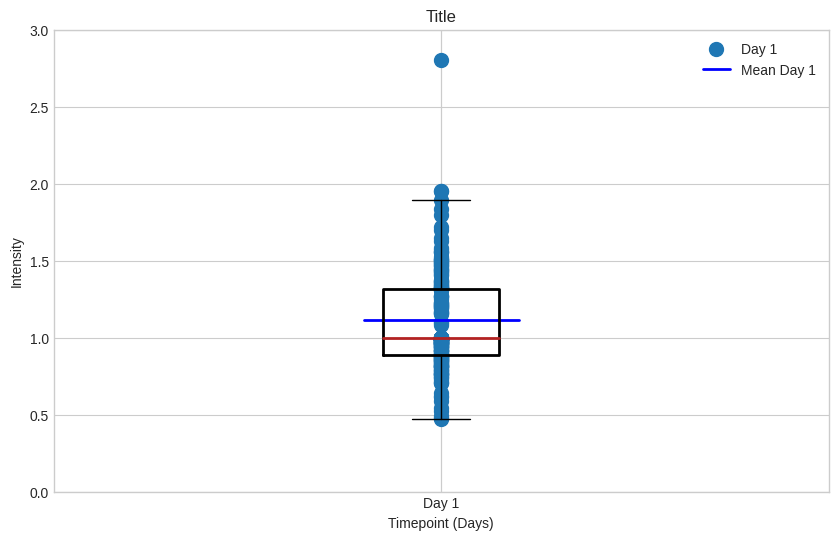

In [ ]:
# Set the style (optional)
plt.style.use("seaborn-whitegrid")

# Create scatterplot
plt.figure(figsize=(10, 6))

print("Starting the plots for each section")
# Scatterplot for Day 1
plt.scatter(np.zeros_like(selected_masks_intensity), selected_masks_intensity, label='Day 1', s=100)

print("Finding the mean lines for each section/day")
# Add mean lines for the section
plt.axhline(y=np.mean(selected_masks_intensity), color='blue', linestyle='-', linewidth=2, label='Mean Day 1', xmin=0.4, xmax=0.6)

# Set x-axis labels
plt.xticks([0], ['Day 1'])

# Set y-axis limit to 3
plt.ylim(0, 3)

# Add labels and title
plt.xlabel('Timepoint (Days)')
plt.ylabel('Intensity')
plt.title('Title')

plt.legend()

# Create separate box plots for each day
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')

print("Plotting the boxplot for each section")
# Boxplot for Day 1
plt.boxplot(selected_masks_intensity, vert=True, positions=[0], boxprops=boxprops, medianprops=medianprops, showfliers=False, labels=['Day 1'])

# Save the plot
plt.savefig(os.path.join(output_folder, "qc_fileName.png"))

# Show the plot
plt.show()


In [ ]:
#@markdown #####If you would like to save a csv file containing the morphology data of each image run this code cell.

# Change the current working directory to the output folder
os.chdir(output_folder2)  # Make sure 'output_folder' points to the desired directory
morphology_data1 = []
for i, image_filename in enumerate(files):

    # Assuming that "processed_images" contains the processed masks
    segmented_image1 = processed_images_qc[i]

    labeled_cells1 = label(segmented_image1)

    for region in regionprops(labeled_cells1):
        cell_id2 = region.label
        area2 = region.area
        perimeter2 = region.perimeter
        crofton_perimeter2 = region.perimeter_crofton
        eccentricity2 = region.eccentricity
        centroid2 = region.centroid

        x_centroid2, y_centroid2 = centroid2

        morphology_data1.append({
            'Image File': image_filename,
            'Cell ID': cell_id2,
            'Area': area2,
            'Perimeter': perimeter2,
            'Crofton Perimeter': crofton_perimeter2,
            'Eccentricity': eccentricity2,
            'Centroid X': x_centroid2,
            'Centroid Y': y_centroid2,
          })


# Graphing for Average Intensity of Each Image
This cell takes the average intensity of each image and outputs a graph showing the distribution of average intensity for each image from each day. This is different from the cell above because it focuses on the image as a whole and not individual cells.
****
To set this cell up you need to go to your output folder(s) and find the csv files for all of your set of images that say "all_images_intensity_results.csv" or "qc_all_images_intensity_results.csv". This just depends whether you did with quality control or not (the qc at the beginning of the file name indicates you did quality control).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#@markdown ####Path to folder containing csv files
# Specify the path to your CSV files
path_file1 = '/content/gdrive/MyDrive/colab_test/HS_09_p2_A2_results/qc_all_images_intensity_results.csv' #@param
path_file2 = '/content/gdrive/MyDrive/colab_test/HS_09_p3_A2_results/qc_all_images_intensity_results.csv' #@param
path_file3 = '/content/gdrive/MyDrive/colab_test/Well_A2_results/qc_all_images_intensity_results.csv' #@param

print("Reading the csv files")

# Read data from CSV files
df1 = pd.read_csv(path_file1)
df2 = pd.read_csv(path_file2)
df3 = pd.read_csv(path_file3)

# Set the style (optional)
plt.style.use("seaborn-whitegrid")

# Create scatterplot
plt.figure(figsize=(10, 6))

print("Plotting the scatterplots on the graph")
# Scatterplot for p2
plt.scatter([0] * len(df1), df1['avg_intensity'], label='p2', s=100)

# Scatterplot for p3
plt.scatter([1] * len(df2), df2['avg_intensity'], label='p3', s=100)

# Scatterplot for p1 (df3)
plt.scatter([2] * len(df3), df3['avg_intensity'], label='p1', s=100)

# Set x-axis labels
plt.xticks([0, 1, 2], ['Day 1', 'Day 2', 'Day 4'])

print("Plotting the mean lines on the graph")
# Plot dashed lines for mean of each group
plt.axhline(y=df1['avg_intensity'].mean(), linestyle='--', color='blue', label='Mean p2')
plt.axhline(y=df2['avg_intensity'].mean(), linestyle='--', color='orange', label='Mean p3')
plt.axhline(y=df3['avg_intensity'].mean(), linestyle='--', color='green', label='Mean p1')

# Add labels and title
plt.xlabel('X-Axis Labels')
plt.ylabel('Average Intensity')
plt.title('Scatterplot of Average Intensity Data')

# Show the legend
plt.legend()

plt.savefig(f'{output_folder}/scatter_plot_all_images.png')

# Show the plot
plt.show()


###Metrics
This code cell uses skimage's regionprops to create a csv file that contains metrics for each cell. If you did not run the quality control code cell then change ``` for image, mask, file_path in zip(images, processed_images_qc, files): ```
to
``` for image, mask, file_path in zip(images, processed_images, files): ```



In [ ]:
import pandas as pd
import os
from skimage.measure import regionprops_table

#@markdown ####File name for the metrics dataset (Do NOT put .csv in this)
metrics_file_name = 'metrics_qc' #@param {type:"string"}

# Create a list for region properties of all cells
all_region_props = []

# Iterate through the processed masks
for mask, file_path in zip(processed_images_qc, files):
    # Get region properties for each cell in the mask
    region_props = regionprops_table(mask, properties=('label', 'centroid', 'area', 'eccentricity', 'perimeter'))

    # Add image index column to region properties
    image_index = os.path.basename(file_path)
    num_cells = len(region_props['label'])
    region_props['Image Index'] = [image_index] * num_cells

    # Append region properties to the list
    all_region_props.append(pd.DataFrame(region_props))  # Convert dict to DataFrame

# Concatenate all region properties into a single DataFrame
region_props_df = pd.concat(all_region_props, ignore_index=True)

# Save region properties to CSV file
csv_file_path = os.path.join(output_folder, f'{metrics_file_name}.csv')
region_props_df.to_csv(csv_file_path, index=False)
print(f"Region properties saved to {csv_file_path}")


Region properties saved to /content/gdrive/MyDrive/colab_test/Well_A3_Output/metrics_qc.csv


In [ ]:
from ipywidgets import interact, widgets
import IPython.display as display
import seaborn as sns
#@markdown ####Path to folder containing csv files
use_folder = "/content/gdrive/MyDrive/colab_test/Well_A2_results/graph" #@param

#@markdown ####Choose the data that you wish to measure
Data_measured = "Area" #@param ["Area", "Perimeter", "Eccentricity"]

images_file_names = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.tif')]

csv_files = [pd.read_csv(os.path.join(use_folder, file)) for file in os.listdir(use_folder) if file.endswith('_morphology.csv')]

image_index = 0

def display_histogram(image_index, data_type):
    # Load data for the selected image and calculate the histogram
    selected_image_data = csv_files[image_index]

    if data_type == "Area":
        data_values = selected_image_data['Area']
        data_label = 'Area'
    elif data_type == "Perimeter":
        data_values = selected_image_data['Perimeter']
        data_label = 'Perimeter'
    elif data_type == "Eccentricity":
        data_values = selected_image_data['Eccentricity']
        data_label = 'Eccentricity'

    Q1 = data_values.quantile(0.10)
    Q3 = data_values.quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clear the previous output
    display.clear_output(wait=True)

    plt.figure(figsize=(10, 6))
    sns.histplot(data_values, kde=True, bins=30)
    plt.axvline(Q1, color='r', linestyle='--', label='Q1 (25th quantile)')
    plt.axvline(data_values.median(), color='g', linestyle='-', label='Median (50th quantile)')
    plt.axvline(Q3, color='b', linestyle='--', label='Q3 (75th quantile)')
    plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower Bound: {lower_bound:.2f}")
    plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f"Upper Bound: {upper_bound:.2f}")
    plt.legend()
    plt.title(f'Histogram of {data_label} for {os.path.basename(images_file_names[image_index])}')
    plt.xlabel(data_label)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Create dropdown widgets for image selection and data type selection
image_selector = widgets.Dropdown(options=[(os.path.basename(image), i) for i, image in enumerate(images_file_names)])
data_selector = widgets.Dropdown(options=["Area", "Perimeter", "Eccentricity"], value=Data_measured, description='Data Type')

# Use the interact function to link the widgets and the display function
interact(display_histogram, image_index=image_selector, data_type=data_selector)


#Viewing Your Processed Images
If you do not already have a software capable of allowing you to view your images I have provided a website. I would recommend to view your processed images at https://ij.imjoy.io/.

I have also provided below the ability to view the processed images. There is a widget that has a drop down menu with a list of all of your files, so just select which one you would like view. **If the image is too small I would recommend changing the axes sizes.**

In [8]:
#@markdown ###This displays the masks of each image and quality control masks
#I chose these libraries because they give the user the ability to select which widget they want to display
from ipywidgets import interact, widgets
import IPython.display as display

image_index = 0
image_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.tif')]

def display_selected_image(image_index):
    img = processed_images[image_index]
    img2 = cleaned_images[image_index]

    plt.figure(figsize=(10, 8)) # This is where you change the size of each axis
    plt.imshow(img)
    plt.axis('on')
    plt.title(image_files[image_index])
    plt.show()

    display.display("This is the processed image after quality control")
    plt.figure(figsize=(10, 8)) # This is where you change the size of each axis
    plt.imshow(img2)
    plt.axis('on')
    plt.title(image_files[image_index])
    plt.show()


# Create a dropdown widget to select the image
image_selector = widgets.Dropdown(options =[(os.path.basename(image_files[i]), i) for i in range(len(image_files))])

# Use the interact function to link the widget and the display function
interact(display_selected_image, image_index = image_selector)

interactive(children=(Dropdown(description='image_index', options=(('Copy of Copy of 20230930_164848_489__Well…

<function __main__.display_selected_image(image_index)>

##Feedback
If you have an recommendations/questions regarding this notebook please fill out the google form. I will try my best to add your suggestions to this notebook.
[Feedback form!](https://forms.gle/HoiBGUbKghqy3m9w9)
